In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch

# make larger figures
plt.rcParams['figure.figsize'] = [15, 10]

In [39]:
def func(input_data):
    """
    Takes a tensor of shape [*, input_size] and produces a tensor 
    of shape [*, output_size].
    """
    assert input_data.ndim >= 1
    a = input_data.sum(dim = -1) - 4
    b = input_data.prod(dim = -1) - 3
    return torch.stack((a, b), dim = -1)

print(func(torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])))
print(func(torch.tensor([2.0, 3.0, 4.0])))

tensor([[  2.,   3.],
        [ 11., 117.],
        [ 20., 501.]])
tensor([ 5., 21.])


In [38]:
def func2(in_data):
    return in_data[:, 0] * in_data[:, 1]

in_data = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
in_data.requires_grad = True
out_data = func2(in_data)
print(in_data)
print(out_data)
grad_data = torch.autograd.grad(
            out_data,
            in_data,
            torch.ones(in_data.shape[0]))[0]
print(grad_data)

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]], requires_grad=True)
tensor([ 2., 12., 30.], grad_fn=<MulBackward0>)
tensor([[2., 1.],
        [4., 3.],
        [6., 5.]])


In [3]:
from torch.autograd.functional import jacobian
print(jacobian(func, torch.tensor([2.0, 3.0])))
print(jacobian(func, torch.tensor([[2.0, 3.0], [4.0, 5.0]])))

tensor([[1., 1.],
        [3., 2.]])
tensor([[[[1., 1.],
          [0., 0.]],

         [[3., 2.],
          [0., 0.]]],


        [[[0., 0.],
          [1., 1.]],

         [[0., 0.],
          [5., 4.]]]])


In [4]:
data = torch.tensor([[2.0, 3.0], [4.0, 5.0], [6.0, 7.0]])
data.requires_grad = True
result = func(data)
print(result)
print(torch.autograd.grad(result[:, 0], data, grad_outputs = torch.ones_like(result[:, 0]), retain_graph = True))
print(torch.autograd.grad(result[:, 1], data, grad_outputs = torch.ones_like(result[:, 1])))

tensor([[ 1.,  3.],
        [ 5., 17.],
        [ 9., 39.]], grad_fn=<StackBackward>)
(tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]),)
(tensor([[3., 2.],
        [5., 4.],
        [7., 6.]]),)


In [5]:
def calc_jacobian(func, input_data):
    """
    Calculates the output and the Jacobian of the function at the given 
    input data. The input data is of shape [*, input_size], while the 
    output data is of shape [*, output_size] and the Jacobian is of size 
    [*, output_size, input_size].
    """
    assert input_data.ndim >= 1
    shape = input_data.shape
    input_data = input_data.reshape((-1, shape[-1]))
    input_data.requires_grad = True
    output_data = func(input_data)
    jacobian_data = torch.empty(
        (input_data.shape[0], output_data.shape[1], input_data.shape[1]))
    for i in range(output_data.shape[1]):
        jacobian_data[:, i, :] = torch.autograd.grad(
            output_data[:, i],
            input_data,
            torch.ones(input_data.shape[0]),
            retain_graph = i + 1 < output_data.shape[1])[0]
    output_data = output_data.reshape(shape[:-1] + output_data.shape[-1:])
    jacobian_data = jacobian_data.reshape(shape[:-1] + jacobian_data.shape[-2:])
    return output_data.detach(), jacobian_data.detach()

print(calc_jacobian(func, torch.tensor([[1.0, 2.0, 3.0, 4.0], [4.0, 5.0, 6.0, 7.0], [2.0, 3.0, 4.0, 5.0]])))
print(calc_jacobian(func, torch.tensor([1.0, 2.0, 3.0, 4.0])))

(tensor([[  6.,  21.],
        [ 18., 837.],
        [ 10., 117.]]), tensor([[[  1.,   1.,   1.,   1.],
         [ 24.,  12.,   8.,   6.]],

        [[  1.,   1.,   1.,   1.],
         [210., 168., 140., 120.]],

        [[  1.,   1.,   1.,   1.],
         [ 60.,  40.,  30.,  24.]]]))
(tensor([ 6., 21.]), tensor([[ 1.,  1.,  1.,  1.],
        [24., 12.,  8.,  6.]]))


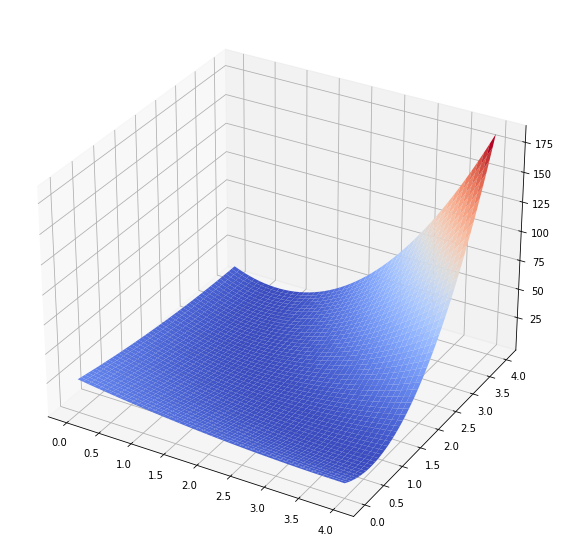

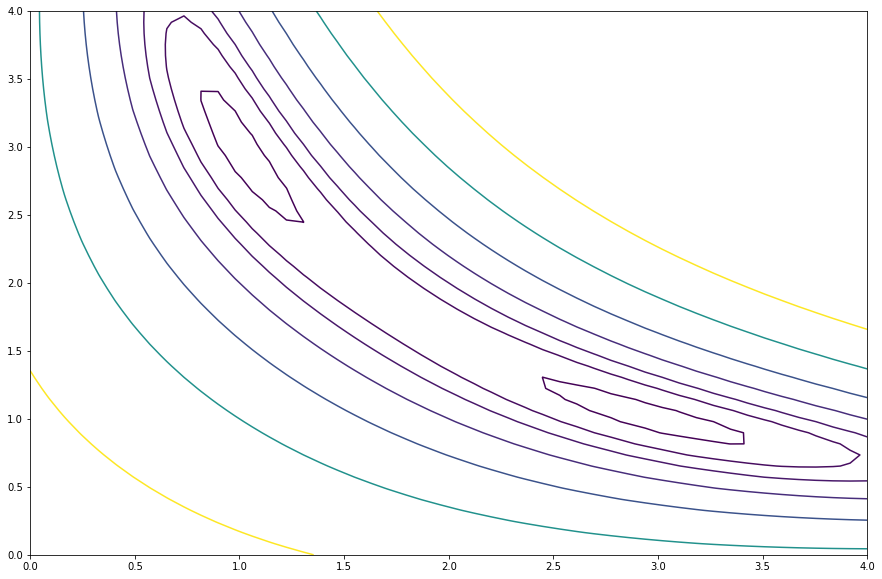

In [6]:
xpos = torch.linspace(0.0, 4.0, 50)
ypos = torch.linspace(0.0, 4.0, 50)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)
output_data, jacobian_data = calc_jacobian(func, input_data)

fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
ax1.plot_surface(
    input_data[:, :, 0], 
    input_data[:, :, 1], 
    output_data.pow(2.0).sum(dim=-1).numpy(),
    cmap=cm.coolwarm)
fig, ax2 = plt.subplots()
ax2.contour(
    input_data[:, :, 0], 
    input_data[:, :, 1], 
    output_data.pow(2.0).sum(dim=-1).numpy(),
    levels=[0.0, 0.1, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0])
plt.show()

In [7]:
s,v,d = torch.randn(2, 3, 4).svd()
print(s.shape, v.shape, d.shape)

torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 4, 3])


In [7]:
def pseudo_inverse(matrix, epsilon=1e-3):
    """
    Takes a tensor of shape [*, rows, cols] and returns a tensor 
    of shape [*, cols, rows]. Only the singular values above
    epsilon are inverted, the rest are zeroed out.
    """
    assert epsilon >= 0.0
    u,s,v = matrix.svd()
    pos = s <= epsilon
    s[pos] = 1.0
    s = 1.0 / s
    s[pos] = 0.0
    a = torch.matmul(v, torch.diag_embed(s))
    return torch.matmul(a, u.transpose(-2, -1))

mat = torch.randn(2, 3, 4)
inv = pseudo_inverse(mat)
print(inv.shape)
print(torch.matmul(mat, inv))
print(torch.matmul(inv, mat))

torch.Size([2, 4, 3])
tensor([[[ 1.0000e+00, -3.5763e-07, -7.7114e-07],
         [ 1.0133e-06,  1.0000e+00,  6.1095e-07],
         [ 5.9605e-07, -1.1921e-07,  1.0000e+00]],

        [[ 1.0000e+00,  1.9372e-07,  1.0431e-07],
         [-4.4703e-08,  1.0000e+00, -5.9605e-08],
         [ 2.9802e-08, -4.4703e-08,  1.0000e+00]]])
tensor([[[ 0.7006,  0.4456, -0.0736,  0.0762],
         [ 0.4456,  0.3369,  0.1095, -0.1134],
         [-0.0736,  0.1095,  0.9819,  0.0187],
         [ 0.0762, -0.1134,  0.0187,  0.9806]],

        [[ 0.9812, -0.0085,  0.0859,  0.1049],
         [-0.0085,  0.9961,  0.0389,  0.0475],
         [ 0.0859,  0.0389,  0.6077, -0.4791],
         [ 0.1049,  0.0475, -0.4791,  0.4149]]])


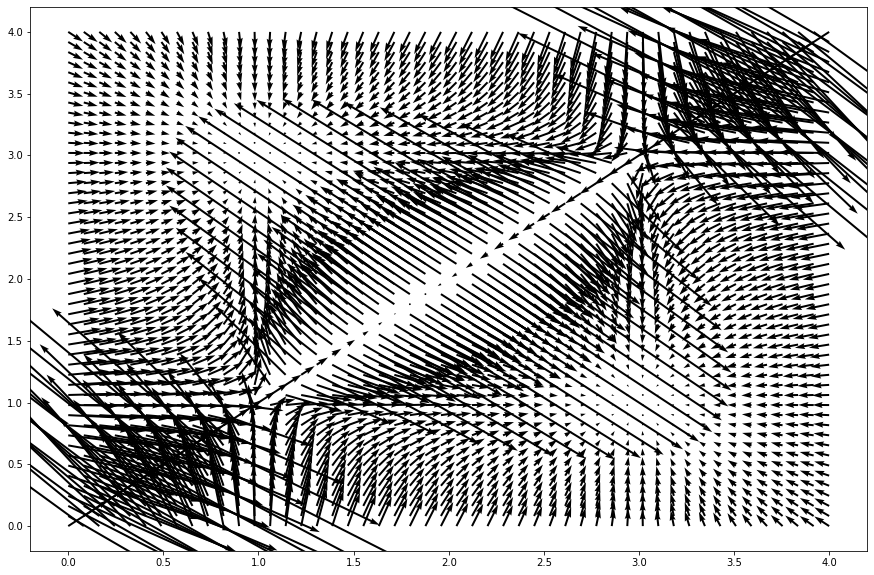

In [9]:
jacobian_inv = pseudo_inverse(jacobian_data, epsilon=0.001)
update = -torch.matmul(jacobian_inv, output_data.unsqueeze(dim=-1)).squeeze(-1)

plt.quiver(
    input_data[:, :, 0], 
    input_data[:, :, 1], 
    update[:, :, 0], 
    update[:, :, 1], 
    angles='xy', scale=50)
plt.show()

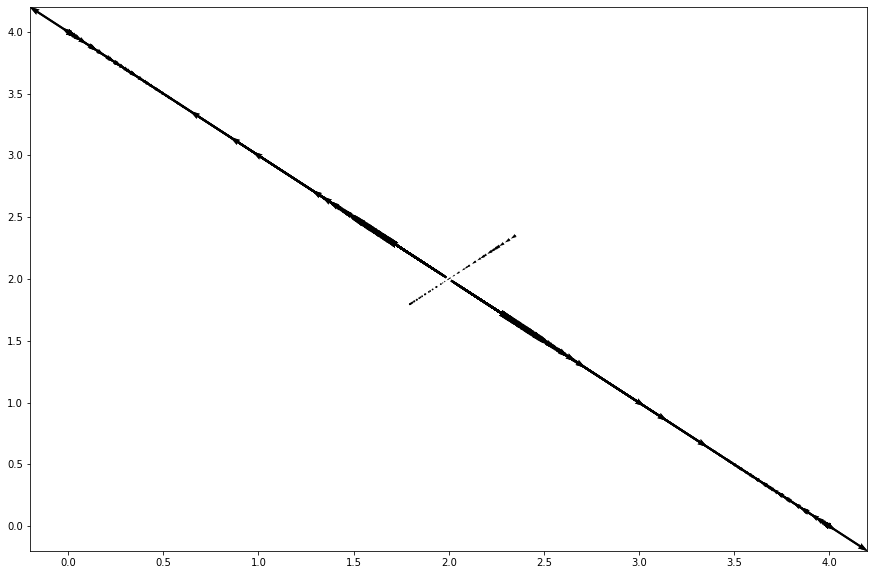

In [10]:
input_data2 = (input_data + update).clip(0.0, 4.0)
output_data2, jacobian_data2 = calc_jacobian(func, input_data2)
jacobian_inv2 = pseudo_inverse(jacobian_data2, epsilon=0.001)
update2 = -torch.matmul(jacobian_inv2, output_data2.unsqueeze(dim=-1)).squeeze(-1)

plt.quiver(
    input_data2[:, :, 0], 
    input_data2[:, :, 1], 
    update2[:, :, 0],
    update2[:, :, 1],
    angles='xy', scale=100)
plt.show()

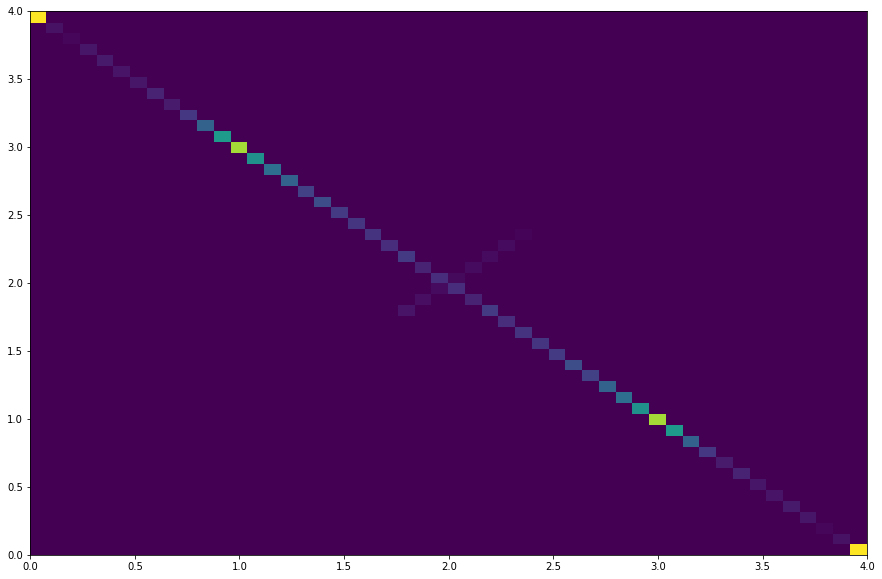

In [11]:
plt.hist2d(input_data2[:, :, 0].flatten().numpy(), input_data2[:, :, 1].flatten().numpy(), bins=50)
plt.show()

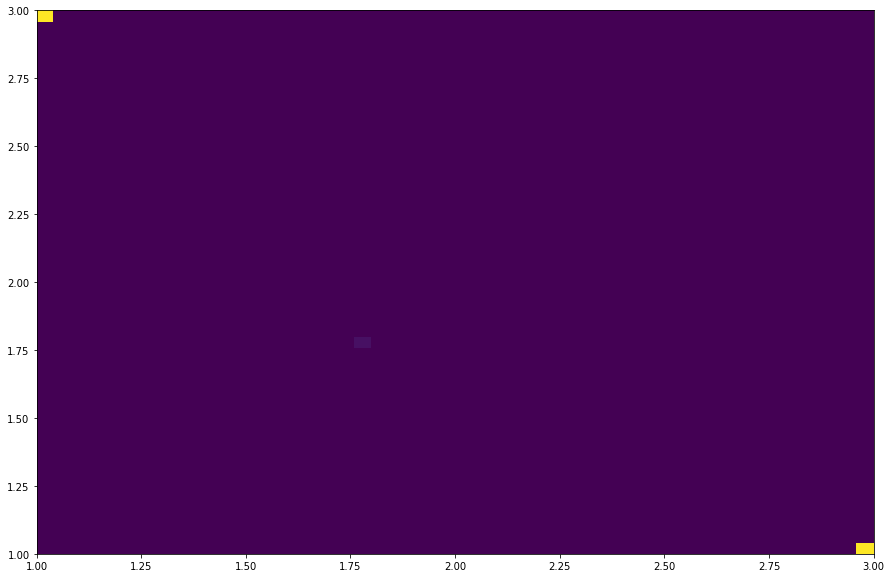

In [12]:
def newton_rapson(func, input_data, iter=10, epsilon=1e-3):
    for _ in range(iter):
        output_data, jacobian_data = calc_jacobian(func, input_data)
        jacobian_inv = pseudo_inverse(jacobian_data, epsilon=epsilon)
        update = torch.matmul(jacobian_inv, output_data.unsqueeze(dim=-1)).squeeze(-1)
        input_data = input_data - update
    return input_data

input_data2 = newton_rapson(func, input_data, iter=10, epsilon=0.01)
input_data2 = input_data2.clip(0.0, 4.0)

plt.hist2d(input_data2[:, :, 0].flatten().numpy(), input_data2[:, :, 1].flatten().numpy(), bins=50)
plt.show()

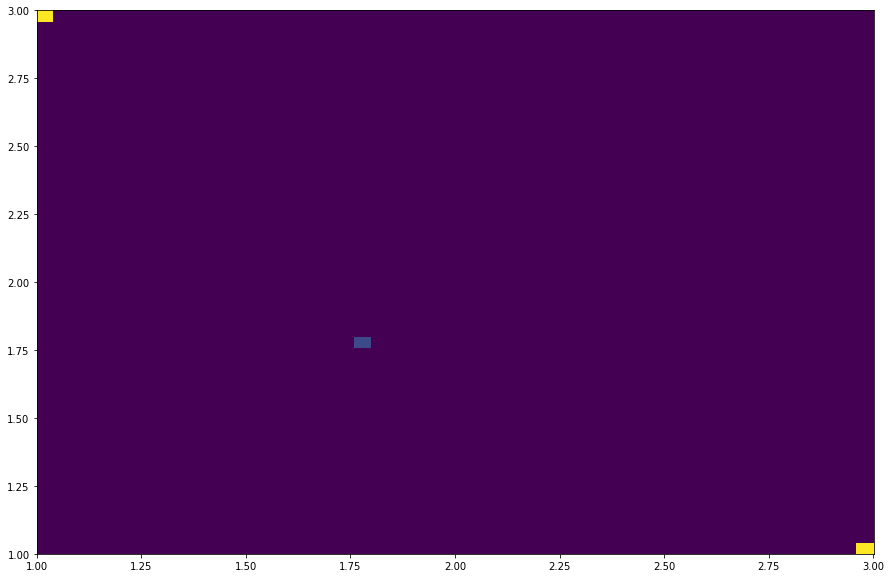

In [13]:
def gradient_descent(f: Callable, in_data: torch.Tensor, it: int):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    learning_rate = 0.01
    in_data = torch.clone(in_data).to(device)
    in_data_grad = torch.ones_like(in_data)
    for _ in range(it):
        for row in range(in_data.shape[0]):
            for col in range(in_data.shape[1]):
                temp_data = torch.clone(in_data[row, col, :])
                temp_data.requires_grad = True
                val = ((f(temp_data) ** 2).sum())
                val.backward()
                in_data_grad[row, col, :] = temp_data.grad
        with torch.no_grad():
            in_data -= learning_rate * in_data_grad

    return in_data.cpu().detach()

xpos = torch.linspace(0.0, 4.0, 10)
ypos = torch.linspace(0.0, 4.0, 10)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)

input_data2 = gradient_descent(f=func, in_data=input_data, it=1000)
input_data2 = input_data2.clip(0.0, 4.0)

plt.hist2d(input_data2[:, :, 0].flatten().numpy(), input_data2[:, :, 1].flatten().numpy(), bins=50)
plt.show()

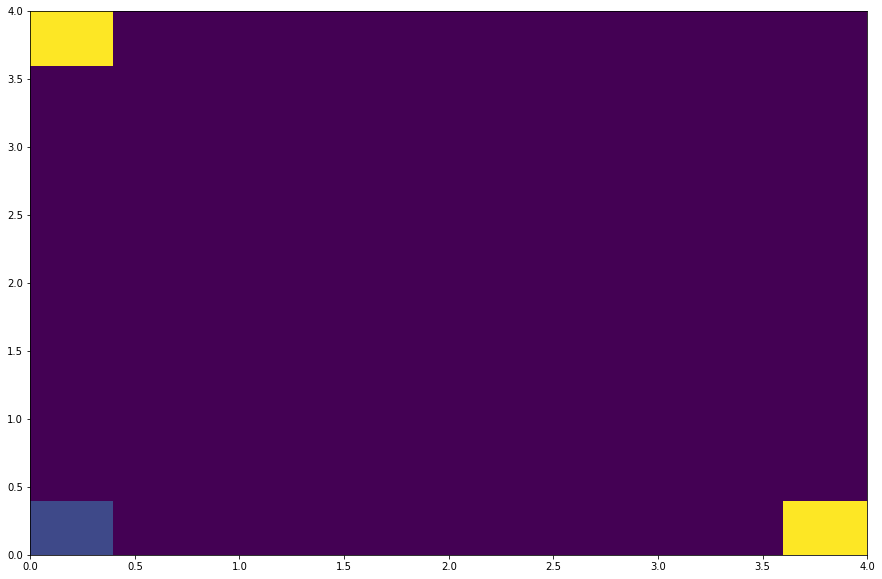

In [14]:
def gradient_descent_2(f: Callable, in_data: torch.Tensor, it: int):
    learning_rate = 0.01
    in_data = torch.clone(in_data)
    in_data.requires_grad = True
    for _ in range(it):
        val = f(in_data)
        in_data.grad = torch.autograd.grad(
            outputs=val,
            inputs=in_data,
            grad_outputs = torch.ones_like(val)
        )[0]
        with torch.no_grad():
            in_data -= learning_rate * in_data.grad
        in_data.grad.zero_()

    return in_data.detach()

xpos = torch.linspace(0.0, 4.0, 10)
ypos = torch.linspace(0.0, 4.0, 10)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)

input_data2 = gradient_descent_2(f=func, in_data=input_data, it=1000)
input_data2 = input_data2.clip(0.0, 4.0)

plt.hist2d(input_data2[:, :, 0].flatten().numpy(), input_data2[:, :, 1].flatten().numpy(), bins=10)
plt.show()

In [15]:
def elliptic_curve(input_data):
    """
    Takes a tensor of shape [*, 2] and produces a tensor 
    of shape [*, 1].
    """
    assert input_data.shape[-1] == 2
    x, y = input_data.unbind(dim=-1)
    return (x * x * x - x - y * y + 0.3).unsqueeze(-1)

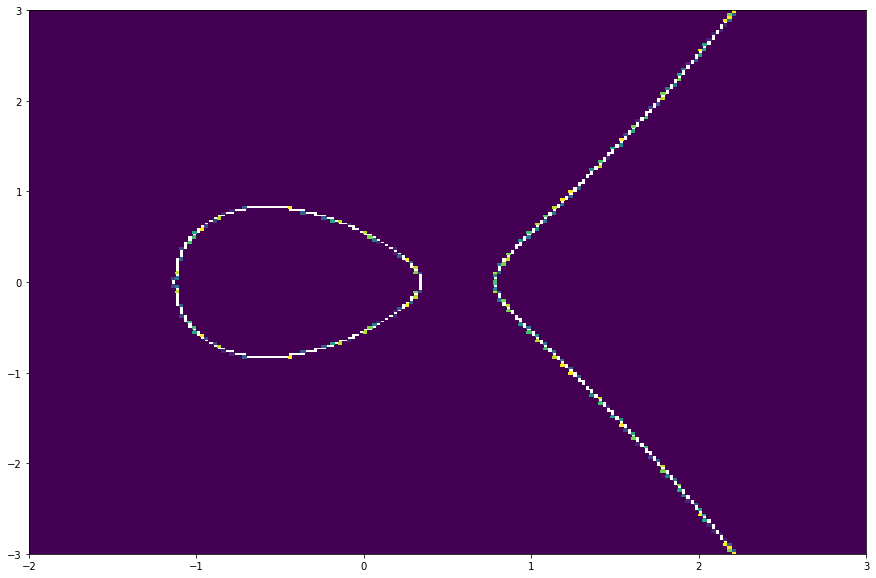

In [16]:
xpos = torch.linspace(-2.0, 3.0, 100)
ypos = torch.linspace(-3.0, 3.0, 100)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)
output_data = newton_rapson(elliptic_curve, input_data, iter=20, epsilon=1e-3)

plt.hist2d(
    output_data[:, :, 0].flatten().numpy(), 
    output_data[:, :, 1].flatten().numpy(), 
    range=[[-2, 3], [-3, 3]],
    bins=200, cmax=10)
plt.show()

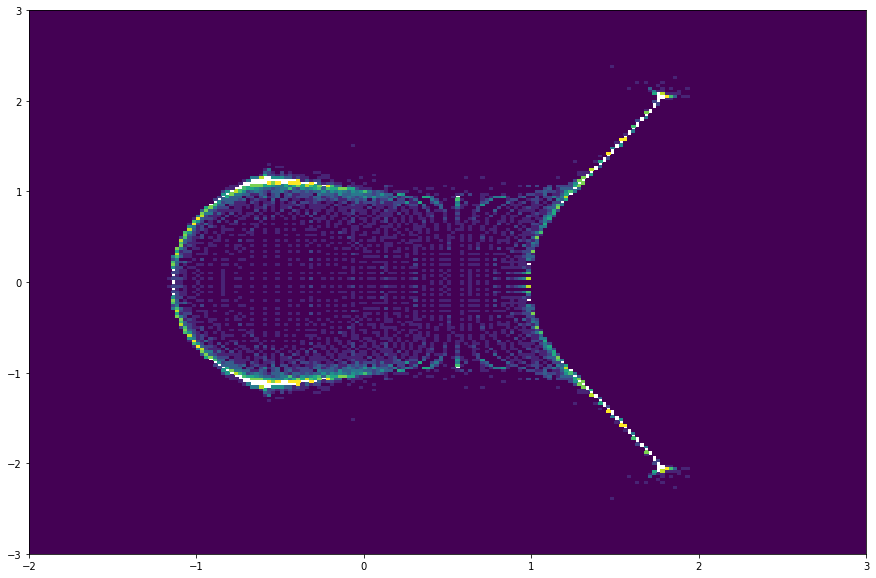

In [17]:
xpos = torch.linspace(-2.0, 3.0, 100)
ypos = torch.linspace(-3.0, 3.0, 100)
input_data = torch.stack(torch.meshgrid(xpos, ypos), dim=-1)
output_data = gradient_descent(f=elliptic_curve, in_data=input_data, it=10)

plt.hist2d(
    output_data[:, :, 0].flatten().numpy(),
    output_data[:, :, 1].flatten().numpy(),
    range=[[-2, 3], [-3, 3]],
    bins=200, cmax=10)
plt.show()